In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from s2sphere import CellId
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import random
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Load data
data_df = pd.read_csv('data/S2Cell_ID_level16.csv', usecols=[2], names=["S2_Cell_ID"], header=0)
vocab_df = pd.read_csv('data/uniqueS2s_level16.csv', names=["Token"])
data = list(map(int, data_df['S2_Cell_ID'].astype(str).str.strip()))
vocab_tokens = list(map(int, vocab_df['Token'].astype(str).str.strip()))
id_to_idx = {token: idx for idx, token in enumerate(vocab_tokens)}
indexed_data = [id_to_idx[cell_id] for cell_id in data if cell_id in id_to_idx]
data_tensor = torch.tensor(indexed_data, dtype=torch.long)
n = int(0.8 * len(data_tensor))
train_data = data_tensor[:n]
val_data = data_tensor[n:]
print("Data points:", len(indexed_data), "| Vocab size:", len(vocab_tokens))

Data points: 967089 | Vocab size: 103244


In [3]:
# Model definition
class SpatialGPT(nn.Module):
    def __init__(self, vocab_size, n_embd=128, n_layer=4, n_head=4, block_size=64):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding = nn.Parameter(torch.zeros(1, block_size, n_embd))
        self.dropout = nn.Dropout(p=0.1)
        self.transformer = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=n_embd, nhead=n_head, batch_first=True),
            num_layers=n_layer
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size

    def forward(self, x, embedded_input=None):
        if embedded_input is None:
            # x should be token IDs: shape [B, T]
            B, T = x.size()
            tok_emb = self.token_embedding(x)
        else:
            # embedded_input should be [B, T, emb_dim]
            tok_emb = embedded_input
            B, T = tok_emb.size(0), tok_emb.size(1)

        pos_emb = self.pos_embedding[:, :T, :]
        x = self.dropout(tok_emb + pos_emb)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(x.device)
        x = self.transformer(x, x, tgt_mask=tgt_mask)
        x = self.ln_f(x)
        return self.head(x)



In [4]:
import time

def train_spatial_gpt_with_early_stopping(
    model, train_data, val_data, vocab_tokens,
    block_size=64, batch_size=32, steps=25001,
    eval_interval=1000, sample_interval=5000,
    checkpoint_path="spatial_gpt.pt", best_model_path="best_spatial_gpt.pt", patience=5
):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, val_losses, times = [], [], []
    best_val_loss = float("inf")
    patience_counter = 0
    start_time = time.time()

    def get_batch(data):
        ix = torch.randint(len(data) - block_size, (batch_size,))
        x = torch.stack([data[i:i+block_size] for i in ix])
        y = torch.stack([data[i+1:i+block_size+1] for i in ix])
        return x.to(device), y.to(device)

    def evaluate(data):
        model.eval()
        xb, yb = get_batch(data)
        with torch.no_grad():
            logits = model(xb)
            loss = loss_fn(logits.view(-1, logits.size(-1)), yb.view(-1)).item()
        return loss

    def plot_losses():
        plt.figure(figsize=(10, 4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.xlabel("Evaluation Steps")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def generate_sample():
        model.eval()
        start = torch.randint(0, len(train_data) - block_size, (1,))
        seed = train_data[start:start+block_size].unsqueeze(0).to(device)
        for _ in range(20):
            logits = model(seed[:, -block_size:])
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            seed = torch.cat([seed, next_token], dim=1)
        return seed[0].tolist()

    for step in range(steps):
        model.train()
        xb, yb = get_batch(train_data)
        logits = model(xb)
        loss = loss_fn(logits.view(-1, logits.size(-1)), yb.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % eval_interval == 0:
            train_loss = loss.item()
            val_loss = evaluate(val_data)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            times.append(time.time() - start_time)

            print(f"Step {step} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {times[-1]:.2f}s")
            plot_losses()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), best_model_path)
                print(f"[Checkpoint] Best model saved -> {best_model_path}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"[Early Stopping] No improvement in {patience} evals. Stopping early at step {step}.")
                    break

        if step % sample_interval == 0 and step > 0:
            sample_tokens = generate_sample()
            s2_ids = [vocab_tokens[tok] for tok in sample_tokens]
            print(f"\n[Sample @ step {step}]: {s2_ids[:10]}...")

        if step % 5000 == 0 and step > 0:
            torch.save(model.state_dict(), checkpoint_path)
            print(f"[Checkpoint] Model saved at step {step} -> {checkpoint_path}")

    torch.save(model.state_dict(), checkpoint_path)
    print(f"[Final] Model saved -> {checkpoint_path}")
    return train_losses, val_losses, times


In [5]:
# Utilities
def s2_to_latlng(s2_id):
    latlng = CellId(s2_id).to_lat_lng()
    return latlng.lat().degrees, latlng.lng().degrees

def haversine_distance(coord1, coord2):
    return haversine(coord1, coord2, unit=Unit.METERS)

def compute_distance_error(actual_coords, gen_coords):
    errors = []
    for a, g in zip(actual_coords, gen_coords):
        dist = haversine_distance(a, g)
        errors.append(dist)
    return np.mean(errors), errors

def plot_haversine_errors(actual_coords, gen_coords):
    _, step_errors = compute_distance_error(actual_coords, gen_coords)
    plt.figure(figsize=(8, 4))
    plt.plot(step_errors, marker='o')
    plt.title("Haversine Error per Step")
    plt.xlabel("Step")
    plt.ylabel("Distance Error (m)")
    plt.grid(True)
    plt.show()

In [6]:
# Sampling
def sample_next_token(logits, temperature=1.0, top_k=0, top_p=0.0):
    logits = logits / temperature
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
    if top_p > 0.0:
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_logits[sorted_indices_to_remove] = -float('Inf')
    if top_k > 0:
        sorted_logits[top_k:] = -float('Inf')
    probs = F.softmax(sorted_logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    return sorted_indices[next_token]

In [7]:
# Evaluation
def compare_actual_vs_generated(model, data, vocab_tokens, block_size=64, max_new_tokens=20, temperature=1.0, top_k=0, top_p=0.0, n_trials=3):
    model.eval()
    results = []
    for trial in range(n_trials):
        start = torch.randint(0, len(data) - block_size - max_new_tokens, (1,))
        seed = data[start:start+block_size].unsqueeze(0).to(device)
        actual = data[start+block_size:start+block_size+max_new_tokens]
        context = seed.clone()
        for _ in range(max_new_tokens):
            logits = model(context[:, -block_size:])
            next_token = sample_next_token(logits[0, -1], temperature, top_k, top_p)
            context = torch.cat([context, next_token.unsqueeze(0)], dim=1)
        generated = context[0, block_size:]
        actual_ids = [vocab_tokens[t.item()] for t in actual]
        gen_ids = [vocab_tokens[t.item()] for t in generated]
        actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
        gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]
        avg_error, _ = compute_distance_error(actual_coords, gen_coords)
        results.append({
            "actual_coords": actual_coords,
            "generated_coords": gen_coords,
            "distance_error": avg_error
        })
        plt.figure(figsize=(8, 6))
        if actual_coords:
            lat_actual, lng_actual = zip(*actual_coords)
            plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
        if gen_coords:
            lat_gen, lng_gen = zip(*gen_coords)
            plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Generated', color='blue')
        plt.title(f"Trial {trial+1}: Distance Error = {avg_error:.2f} m")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid(True)
        plt.show()
        plot_haversine_errors(actual_coords, gen_coords)
    return results

Step 0 | Train Loss: 11.7224 | Val Loss: 11.7023 | Time: 18.01s


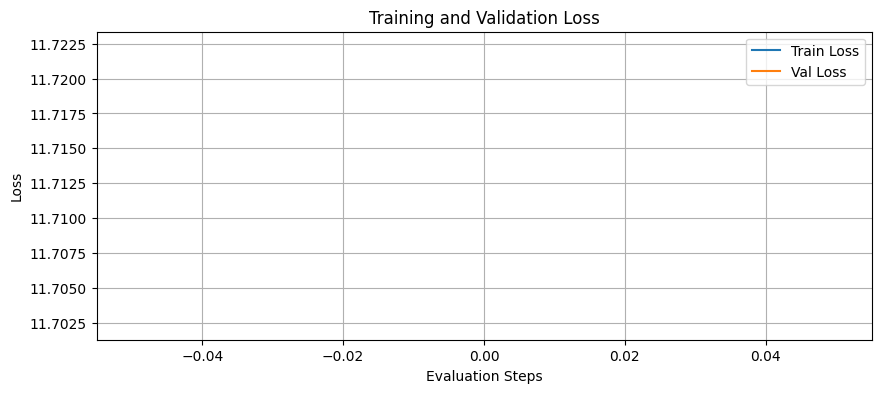

[Checkpoint] Best model saved -> best_spatial_gpt.pt
Step 1000 | Train Loss: 10.3122 | Val Loss: 10.7359 | Time: 98.50s


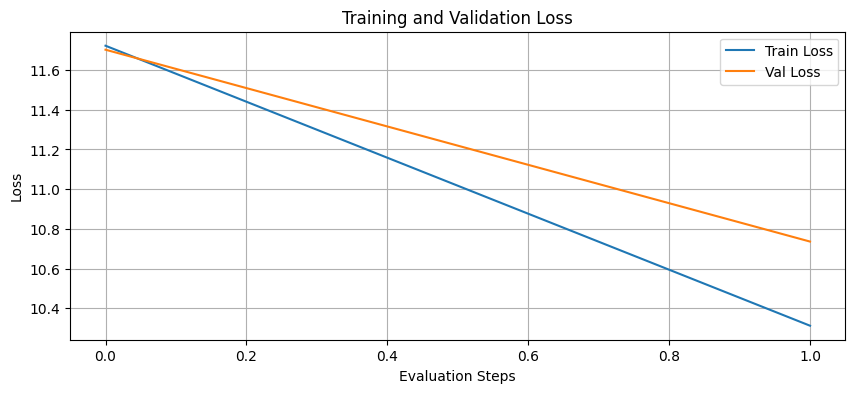

[Checkpoint] Best model saved -> best_spatial_gpt.pt
Step 2000 | Train Loss: 10.3335 | Val Loss: 11.0526 | Time: 173.85s


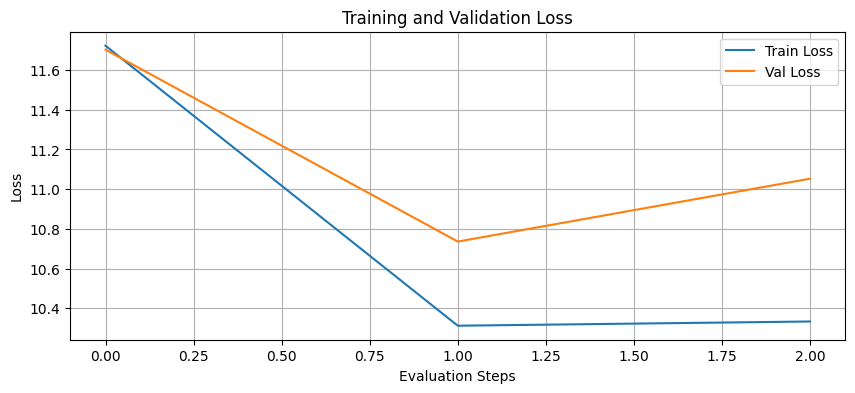

Step 3000 | Train Loss: 10.1991 | Val Loss: 11.1159 | Time: 248.35s


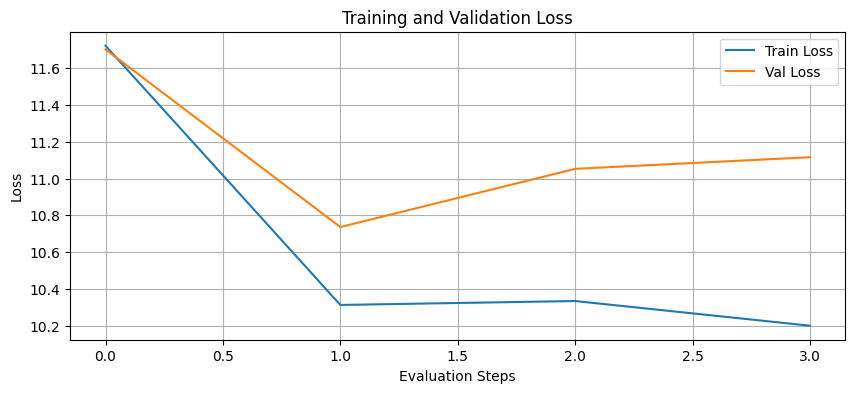

Step 4000 | Train Loss: 9.8077 | Val Loss: 11.0535 | Time: 322.81s


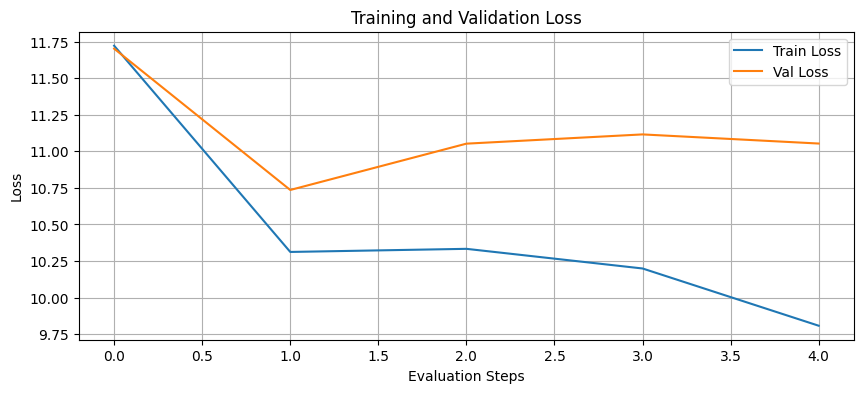

Step 5000 | Train Loss: 9.7693 | Val Loss: 11.0612 | Time: 398.18s


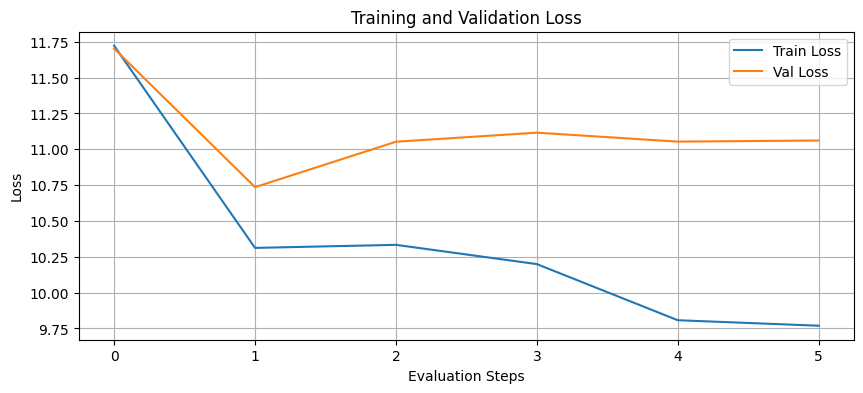


[Sample @ step 5000]: [11892208136716550144, 12687452673557921792, 12708385207602905088, 11831426772082098176, 11831426772082098176, 12687517851297251328, 12712759448184029184, 12708384458667982848, 12711821418736648192, 11915180088737398784]...
[Checkpoint] Model saved at step 5000 -> spatial_gpt.pt
Step 6000 | Train Loss: 9.5844 | Val Loss: 11.0918 | Time: 474.56s


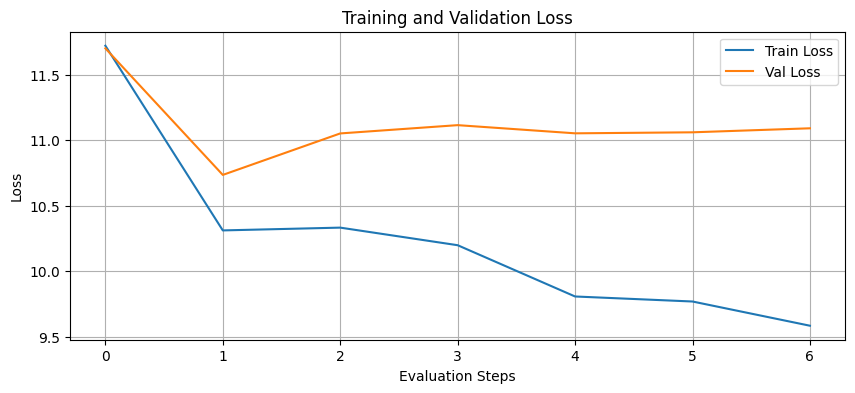

[Early Stopping] No improvement in 5 evals. Stopping early at step 6000.
[Final] Model saved -> spatial_gpt.pt


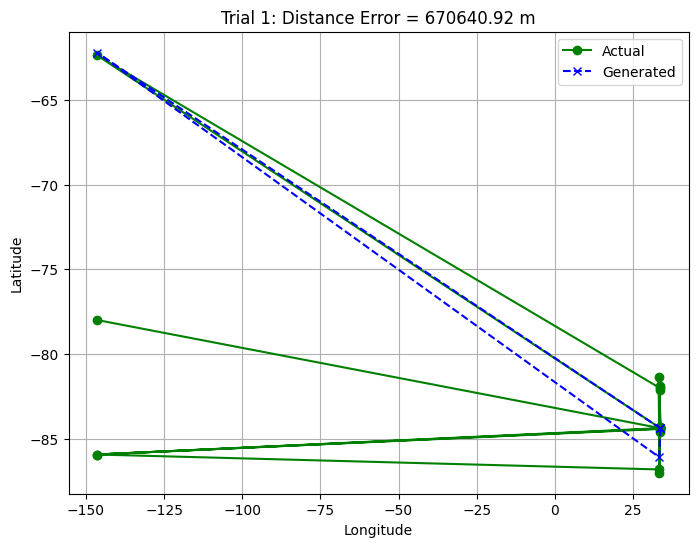

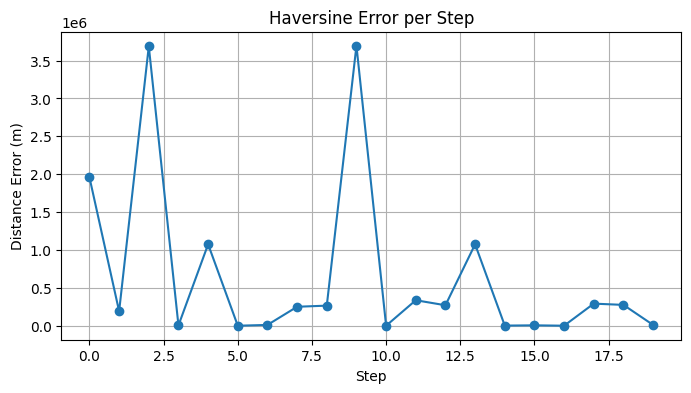

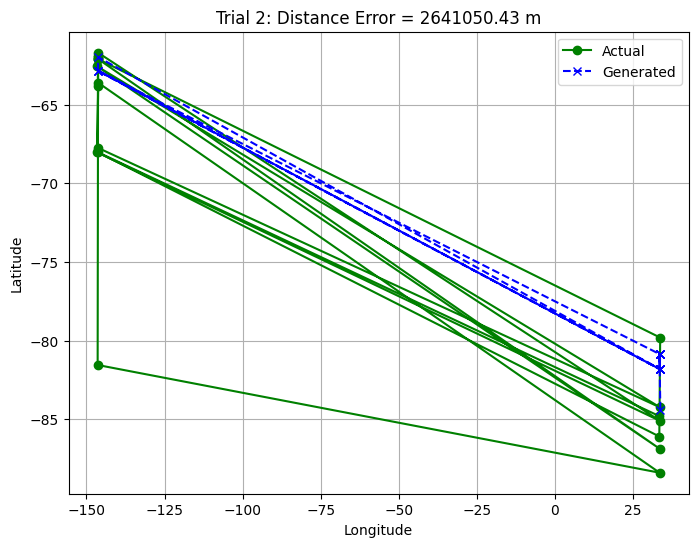

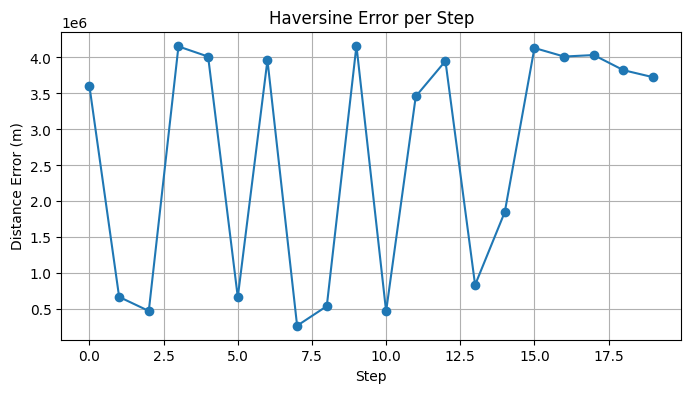

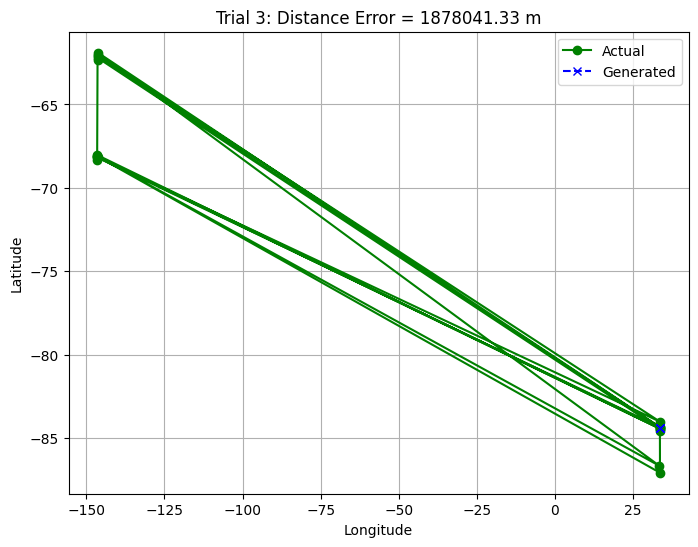

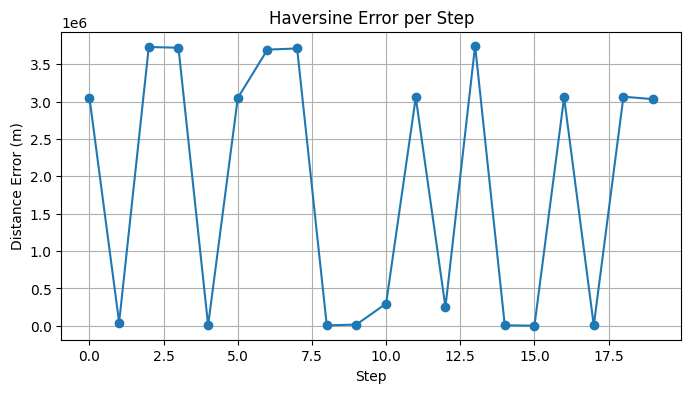

Average distance errors (m): [np.float64(670640.9155362338), np.float64(2641050.426480352), np.float64(1878041.3262947048)]


In [8]:
# Train and evaluate
model = SpatialGPT(vocab_size=len(vocab_tokens), block_size=64).to(device)
train_losses, val_losses, times = train_spatial_gpt_with_early_stopping(
    model=model,
    train_data=train_data,
    val_data=val_data,
    vocab_tokens=vocab_tokens,
    steps=25001
)


results = compare_actual_vs_generated(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    block_size=64,
    max_new_tokens=20,
    temperature=1.0,
    top_k=20,
    top_p=0.9,
    n_trials=3
)

print("Average distance errors (m):", [r['distance_error'] for r in results])


In [9]:
def sample_next_token(logits, temperature=1.0, top_k=0, top_p=0.0, vocab_size=None):
    logits = logits / temperature
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    if top_p > 0.0:
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_logits[sorted_indices_to_remove] = -float('Inf')
    if top_k > 0:
        sorted_logits[top_k:] = -float('Inf')

    probs = F.softmax(sorted_logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    sampled_token = sorted_indices[next_token]

    if vocab_size is not None:
        sampled_token = torch.clamp(sampled_token, max=vocab_size - 1)

    return sampled_token


def plot_single_comparison(model, data, vocab_tokens, block_size=64, max_new_tokens=20,
                           temperature=1.0, top_k=0, top_p=0.0):
    model.eval()
    vocab_size = len(vocab_tokens)

    start = torch.randint(0, len(data) - block_size - max_new_tokens, (1,))
    seed = data[start:start + block_size].unsqueeze(0).to(device)
    actual = data[start + block_size:start + block_size + max_new_tokens]

    context = seed.clone()
    with torch.no_grad():
        for _ in range(max_new_tokens):
            input_seq = context[:, -block_size:]

            assert torch.max(input_seq) < vocab_size, \
                f"Token index out of bounds: max {torch.max(input_seq)} vs vocab size {vocab_size}"

            logits = model(input_seq)
            next_token = sample_next_token(logits[0, -1], temperature, top_k, top_p, vocab_size=vocab_size)
            context = torch.cat([context, next_token.unsqueeze(0)], dim=1)

    generated = context[0, block_size:]
    actual_ids = [vocab_tokens[t.item()] for t in actual]
    gen_ids = [vocab_tokens[t.item()] for t in generated]
    actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
    gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]

    # Path Plot
    plt.figure(figsize=(8, 6))
    lat_actual, lng_actual = zip(*actual_coords)
    lat_gen, lng_gen = zip(*gen_coords)
    plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
    plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Generated', color='blue')
    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Actual vs Generated Path\nTemp={temperature}, Top-k={top_k}, Top-p={top_p}")
    plt.grid(True)
    plt.show()

    # Haversine Error Plot
    step_errors = [haversine_distance(a, g) for a, g in zip(actual_coords, gen_coords)]
    plt.figure(figsize=(8, 4))
    plt.plot(step_errors, marker='o', color='orange')
    plt.title("Haversine Distance per Step")
    plt.xlabel("Step")
    plt.ylabel("Distance (meters)")
    plt.grid(True)
    plt.show()

    return {
        "actual_tokens": actual.tolist(),
        "generated_tokens": generated.tolist(),
        "actual_coords": actual_coords,
        "generated_coords": gen_coords,
        "step_errors_m": step_errors
    }


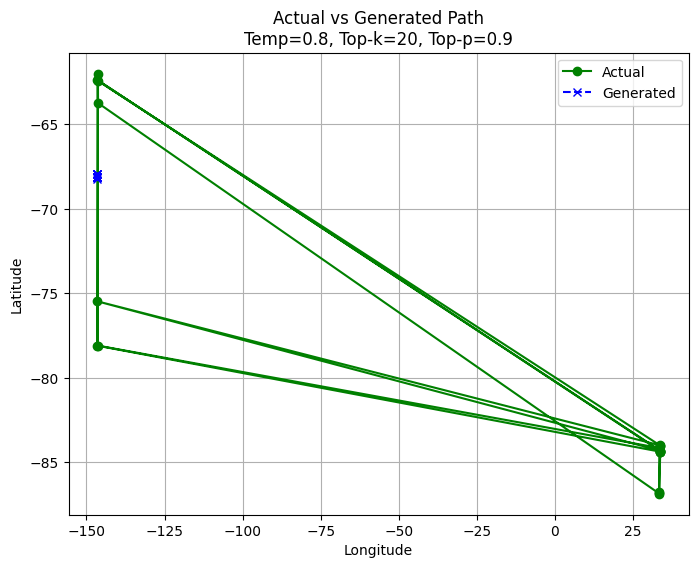

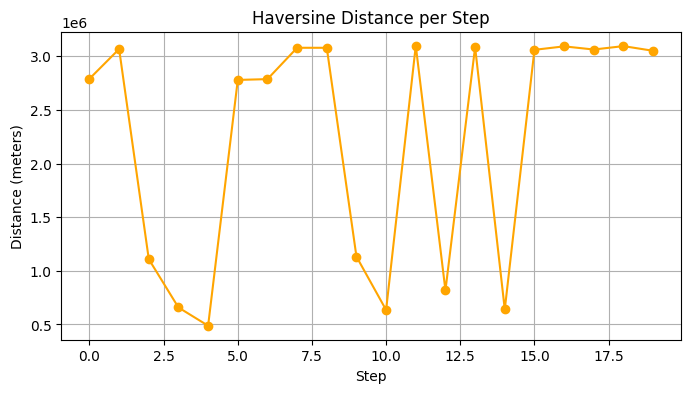

Step-by-step Haversine Errors (meters): [2790477.1592641477, 3067705.4058078066, 1108855.8591813277, 658470.1732055733, 488547.18110797275, 2779757.22663578, 2787099.5671296157, 3079428.365702908, 3079232.4485507826, 1133048.788779662, 635364.2266764013, 3098539.9692803863, 817420.4678592561, 3085914.7305837455, 640382.9878727386, 3060269.1864593797, 3092606.6783400085, 3063099.190853535, 3094889.5787394703, 3051305.977009911]


In [10]:
result = plot_single_comparison(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    block_size=64,
    max_new_tokens=20,
    temperature=0.8,
    top_k=20,
    top_p=0.9
)

print("Step-by-step Haversine Errors (meters):", result["step_errors_m"])

def plot_bar_comparison(results_dict):
    attacks = list(results_dict.keys())
    means = [np.mean([r["distance_error"] for r in results_dict[atk]]) for atk in attacks]
    stds = [np.std([r["distance_error"] for r in results_dict[atk]]) for atk in attacks]

    plt.figure(figsize=(10, 5))
    plt.bar(attacks, means, yerr=stds, capsize=5, color='skyblue')
    plt.ylabel("Avg. Haversine Error (meters)")
    plt.title("Comparison of Adversarial Attack Effects")
    plt.grid(True, axis='y')
    plt.show()


Add Adversarial Attack Modules for SpatialGPT by using three attacks:

FGSM (Fast Gradient Sign Method)

PGD (Projected Gradient Descent)

Random Noise Attack (sanity check)

These will use input token sequences and perturb the embedding space before passing to the model.

In [11]:
import torch
import torch.nn.functional as F

def fgsm_attack(model, x, y, epsilon, loss_fn):
    # Get token embeddings and enable gradient
    tok_emb = model.token_embedding(x).detach().clone().requires_grad_(True)

    logits = model(x, embedded_input=tok_emb)
    loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
    model.zero_grad()
    loss.backward()

    grad_sign = tok_emb.grad.data.sign()
    perturbed_emb = tok_emb + epsilon * grad_sign

    return perturbed_emb.detach()


def pgd_attack(model, x, y, epsilon, alpha, iters, loss_fn):
    # Start with clean embedding
    orig_emb = model.token_embedding(x).detach()
    x_adv = orig_emb.clone().requires_grad_(True)

    for _ in range(iters):
        logits = model(x, embedded_input=x_adv)
        loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))

        model.zero_grad()
        loss.backward()

        # Gradient step
        grad_sign = x_adv.grad.data.sign()
        x_adv = x_adv + alpha * grad_sign

        # Project perturbation
        perturbation = torch.clamp(x_adv - orig_emb, min=-epsilon, max=epsilon)
        x_adv = (orig_emb + perturbation).detach().requires_grad_(True)

    return x_adv.detach()


def random_noise_attack(model, x, y=None, epsilon=2, **kwargs):
    # Add random noise to the token embedding
    tok_emb = model.token_embedding(x).detach()
    noise = torch.randn_like(tok_emb) * epsilon
    return (tok_emb + noise).detach()


In [12]:
def evaluate_under_attack(model, data, attack_fn, attack_name="FGSM", **kwargs):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    block_size = kwargs.get("block_size", 64)
    batch_size = kwargs.get("batch_size", 32)

    ix = torch.randint(0, len(data) - block_size - 1, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)

    # Get adversarial embedding
    adv_emb = attack_fn(model, x, y, loss_fn=loss_fn, **kwargs)

    # Forward using perturbed embedding
    logits = model(x, embedded_input=adv_emb)
    loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1)).item()

    print(f"[{attack_name}] Eval Loss under attack: {loss:.4f}")



In [13]:
# FGSM Attack (ε = 0.1)
evaluate_under_attack(model, val_data, fgsm_attack, attack_name="FGSM", epsilon=0.1)

# PGD Attack (ε = 0.1, α = 0.01, iters = 5)
evaluate_under_attack(model, val_data, pgd_attack, attack_name="PGD", epsilon=0.1, alpha=0.01, iters=5)

# Random Noise Attack
evaluate_under_attack(model, val_data, random_noise_attack, attack_name="Random", epsilon=0.1)


[FGSM] Eval Loss under attack: 11.7161
[PGD] Eval Loss under attack: 11.5276
[Random] Eval Loss under attack: 11.0222


In [18]:
def compare_under_attack(model, data, vocab_tokens, attack_fn, attack_name="FGSM",
                         block_size=64, max_new_tokens=20, temperature=1.0, top_k=0, top_p=0.0,
                         n_trials=1, **kwargs):
    model.eval()
    results = []

    for trial in range(n_trials):
        # Seed and target
        start = torch.randint(0, len(data) - block_size - max_new_tokens, (1,))
        seed = data[start:start + block_size].unsqueeze(0).to(device)
        actual = data[start + block_size:start + block_size + max_new_tokens]

        # Fake label just for gradient (use next token)
        y_dummy = data[start + 1:start + block_size + 1].unsqueeze(0).to(device)

        # Adversarially perturb the seed
        seed_adv = attack_fn(model, seed, y_dummy, loss_fn=nn.CrossEntropyLoss(), **kwargs)

        # Generate with perturbed seed
        context = seed_adv.clone()
        for _ in range(max_new_tokens):
            input_ids = seed[:, -block_size:]
            input_emb = context[:, -block_size:]
            logits = model(input_ids, embedded_input=input_emb)

            next_token = sample_next_token(logits[0, -1], temperature, top_k, top_p, vocab_size=len(vocab_tokens))
            context = torch.cat([context, model.token_embedding(next_token).unsqueeze(0)], dim=1)
            seed = torch.cat([seed, next_token.unsqueeze(0)], dim=1)
        generated = context[0, block_size:]

        actual_ids = [vocab_tokens[t.item()] for t in actual]
        gen_ids = [vocab_tokens[t.item()] for t in torch.argmax(generated, dim=-1)]
        actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
        gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]
        avg_error, step_errors = compute_distance_error(actual_coords, gen_coords)

        # Plot spatial paths
        plt.figure(figsize=(8, 6))
        lat_actual, lng_actual = zip(*actual_coords)
        lat_gen, lng_gen = zip(*gen_coords)
        plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
        plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Adversarial Gen', color='red')
        plt.title(f"[{attack_name}] Trial {trial+1} - Distance Error: {avg_error:.1f} m")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot haversine error
        plt.figure(figsize=(8, 4))
        plt.plot(step_errors, marker='o', color='orange')
        plt.title(f"[{attack_name}] Haversine Distance Error per Step")
        plt.xlabel("Step")
        plt.ylabel("Distance Error (m)")
        plt.grid(True)
        plt.show()

        results.append({
            "attack": attack_name,
            "actual_coords": actual_coords,
            "generated_coords": gen_coords,
            "step_errors": step_errors,
            "distance_error": avg_error
        })

    return results


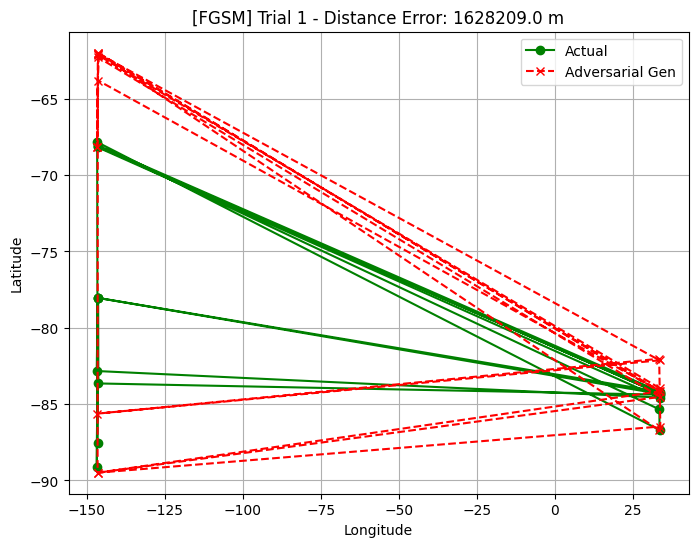

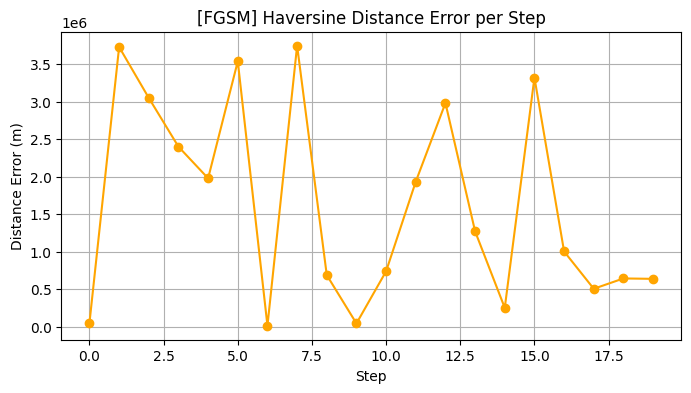

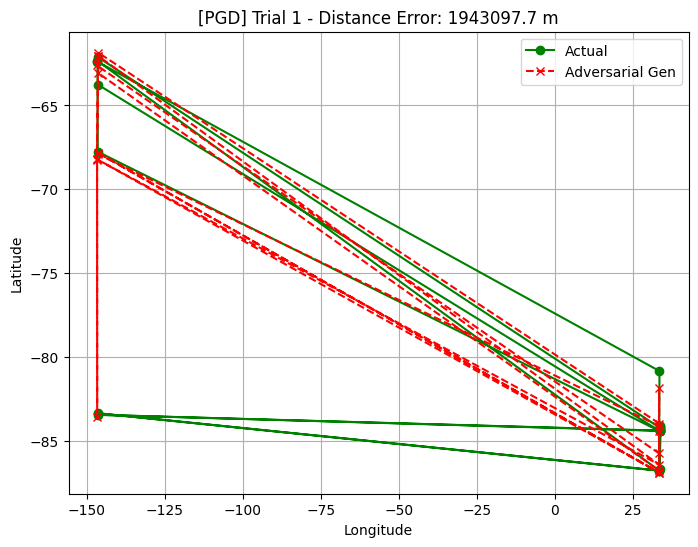

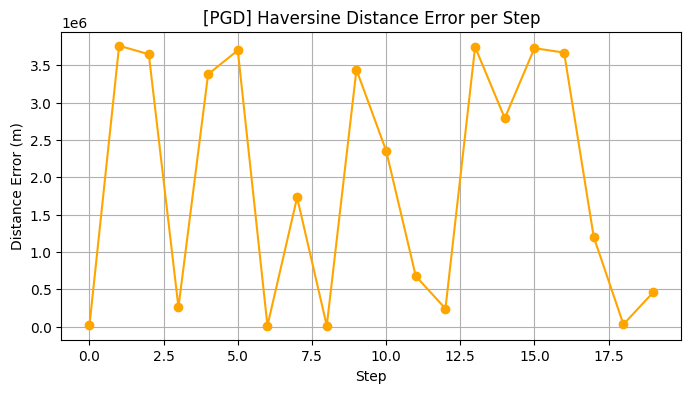

In [19]:
# FGSM Visualization
results_fgsm = compare_under_attack(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    attack_fn=fgsm_attack,
    attack_name="FGSM",
    epsilon=0.1,
    n_trials=1
)

# PGD Visualization
results_pgd = compare_under_attack(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    attack_fn=pgd_attack,
    attack_name="PGD",
    epsilon=0.1,
    alpha=0.01,
    iters=5,
    n_trials=1
)

In [20]:

def sample_next_token(logits, temperature=1.0, top_k=0, top_p=0.0, vocab_size=None):
    logits = logits / temperature
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    if top_p > 0.0:
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_logits[sorted_indices_to_remove] = -float('Inf')
    if top_k > 0:
        sorted_logits[top_k:] = -float('Inf')

    probs = F.softmax(sorted_logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    sampled_token = sorted_indices[next_token]

    if vocab_size is not None:
        sampled_token = torch.clamp(sampled_token, max=vocab_size - 1)

    return sampled_token


In [21]:

def plot_single_comparison(model, data, vocab_tokens, block_size=64, max_new_tokens=20,
                           temperature=0.8, top_k=0, top_p=0.0):
    model.eval()
    vocab_size = len(vocab_tokens)

    start = torch.randint(0, len(data) - block_size - max_new_tokens, (1,))
    seed = data[start:start + block_size].unsqueeze(0).to(device)
    actual = data[start + block_size:start + block_size + max_new_tokens]

    context = seed.clone()
    with torch.no_grad():
        for _ in range(max_new_tokens):
            input_seq = context[:, -block_size:]
            max_token = torch.max(input_seq).item()
            print(f"[DEBUG] max token index: {max_token} | vocab size: {vocab_size}")
            assert max_token < vocab_size, f"Token index {max_token} out of bounds for vocab size {vocab_size}"

            logits = model(input_seq)
            next_token = sample_next_token(logits[0, -1], temperature, top_k, top_p, vocab_size=vocab_size)
            context = torch.cat([context, next_token.unsqueeze(0)], dim=1)

    generated = context[0, block_size:]
    actual_ids = [vocab_tokens[t.item()] for t in actual]
    gen_ids = [vocab_tokens[t.item()] for t in generated]
    actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
    gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]

    # Plot spatial paths
    plt.figure(figsize=(8, 6))
    lat_actual, lng_actual = zip(*actual_coords)
    lat_gen, lng_gen = zip(*gen_coords)
    plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
    plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Generated', color='blue')
    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Actual vs Generated Spatial Path\nTemp={temperature}, Top-k={top_k}, Top-p={top_p}")
    plt.grid(True)
    plt.show()

    step_errors = [haversine_distance(a, g) for a, g in zip(actual_coords, gen_coords)]
    plt.figure(figsize=(8, 4))
    plt.plot(step_errors, marker='o', color='orange')
    plt.title("Haversine Distance Error per Step")
    plt.xlabel("Step")
    plt.ylabel("Distance Error (meters)")
    plt.grid(True)
    plt.show()

    return {
        "actual_tokens": actual.tolist(),
        "generated_tokens": generated.tolist(),
        "actual_coords": actual_coords,
        "generated_coords": gen_coords,
        "step_errors_m": step_errors
    }


In [30]:

def compare_under_attack(model, data, vocab_tokens, attack_fn, attack_name="FGSM",
                         block_size=64, max_new_tokens=20, temperature=1.0, top_k=0, top_p=0.0,
                         n_trials=1, **kwargs):
    model.eval()
    results = []

    for trial in range(n_trials):
        start = torch.randint(0, len(data) - block_size - max_new_tokens, (1,))
        seed = data[start:start + block_size].unsqueeze(0).to(device)
        actual = data[start + block_size:start + block_size + max_new_tokens]

        y_dummy = data[start + 1:start + block_size + 1].unsqueeze(0).to(device)

        seed_adv = attack_fn(model, seed, y_dummy, loss_fn=nn.CrossEntropyLoss(), **kwargs)

        context = seed_adv.clone()  # embeddings
        token_context = seed.clone()  # token IDs

        for _ in range(max_new_tokens):
            input_ids = token_context[:, -block_size:]
            input_emb = context[:, -block_size:]
            logits = model(input_ids, embedded_input=input_emb)

            next_token = sample_next_token(logits[0, -1], temperature, top_k, top_p, vocab_size=len(vocab_tokens))
            next_emb = model.token_embedding(next_token).unsqueeze(0)

            token_context = torch.cat([token_context, next_token.unsqueeze(0)], dim=1)
            context = torch.cat([context, next_emb], dim=1)

        generated = token_context[0, block_size:]
        actual_ids = [vocab_tokens[t.item()] for t in actual]
        gen_ids = [vocab_tokens[t.item()] for t in generated]
        actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
        gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]
        avg_error, step_errors = compute_distance_error(actual_coords, gen_coords)

        plt.figure(figsize=(8, 6))
        lat_actual, lng_actual = zip(*actual_coords)
        lat_gen, lng_gen = zip(*gen_coords)
        plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
        plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Adversarial Gen', color='red')
        plt.title(f"[{attack_name}] Trial {trial+1} - Distance Error: {avg_error:.1f} m")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.plot(step_errors, marker='o', color='orange')
        plt.title(f"[{attack_name}] Haversine Distance Error per Step")
        plt.xlabel("Step")
        plt.ylabel("Distance Error (m)")
        plt.grid(True)
        plt.show()

        results.append({
            "attack": attack_name,
            "actual_coords": actual_coords,
            "generated_coords": gen_coords,
            "step_errors": step_errors,
            "distance_error": avg_error
        })

    return results


[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 103244
[DEBUG] max token index: 101138 | vocab size: 

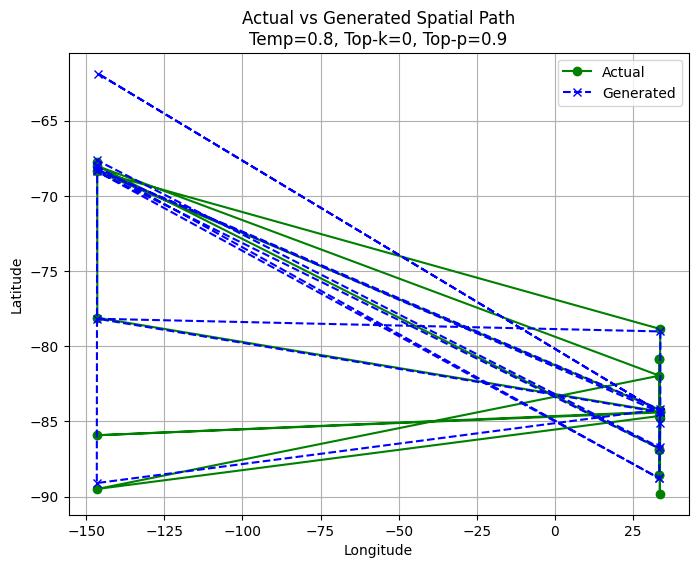

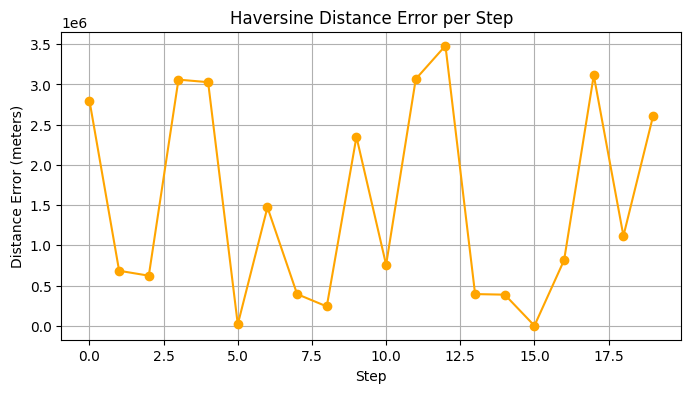

{'actual_tokens': [88127,
  14808,
  100391,
  90354,
  58037,
  36219,
  20837,
  29623,
  1224,
  83194,
  12103,
  9823,
  11804,
  30972,
  20837,
  37997,
  78753,
  60498,
  42544,
  55988],
 'generated_tokens': [60984,
  94084,
  67287,
  85168,
  99747,
  38396,
  3037,
  75165,
  14248,
  29696,
  16906,
  99747,
  62052,
  87234,
  33850,
  9741,
  53034,
  68228,
  6962,
  67240],
 'actual_coords': [(-86.9050340293971, 33.47534608649915),
  (-84.74450516381604, 33.76955346681938),
  (-89.81132978062429, 33.622775185546885),
  (-84.2274055923678, 33.679939460649784),
  (-68.37288709420258, -146.62890409965462),
  (-78.85912790443444, 33.75611804303871),
  (-88.58038801327098, 33.49732455566265),
  (-80.85172417484624, 33.49598376120056),
  (-84.64262072842213, 33.47109007521591),
  (-89.4978998278185, -146.5622724167555),
  (-81.96225793175712, 33.473835427019864),
  (-68.01902157421293, -146.49635571138728),
  (-86.80873794589809, 33.507890596521094),
  (-80.84624002016439, 

In [31]:
plot_single_comparison(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    block_size=64,
    max_new_tokens=20,
    temperature=0.8,
    top_k=0,
    top_p=0.9
)


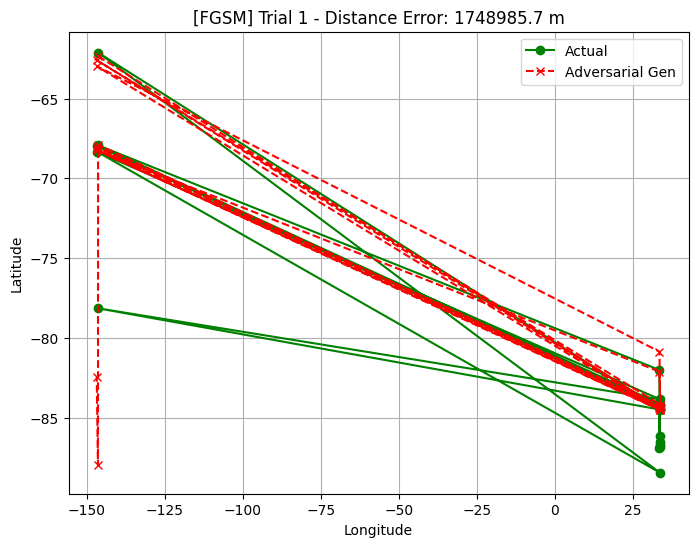

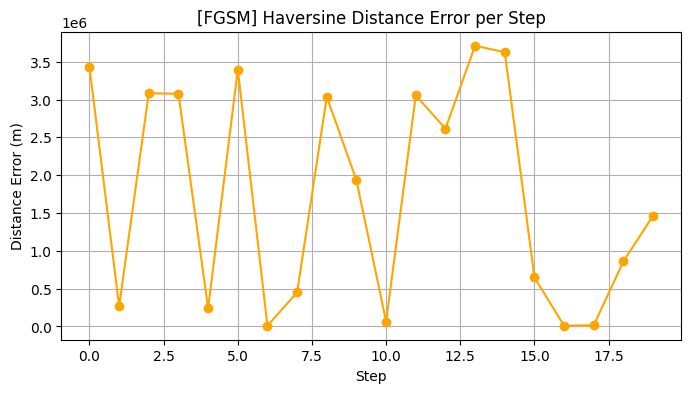

In [32]:
results_fgsm = compare_under_attack(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    attack_fn=fgsm_attack,          # or pgd_attack
    attack_name="FGSM",             # or "PGD"
    epsilon=0.1,
    n_trials=1,
    block_size=64,
    max_new_tokens=20,
    temperature=1.0,
    top_k=0,
    top_p=0.0
)


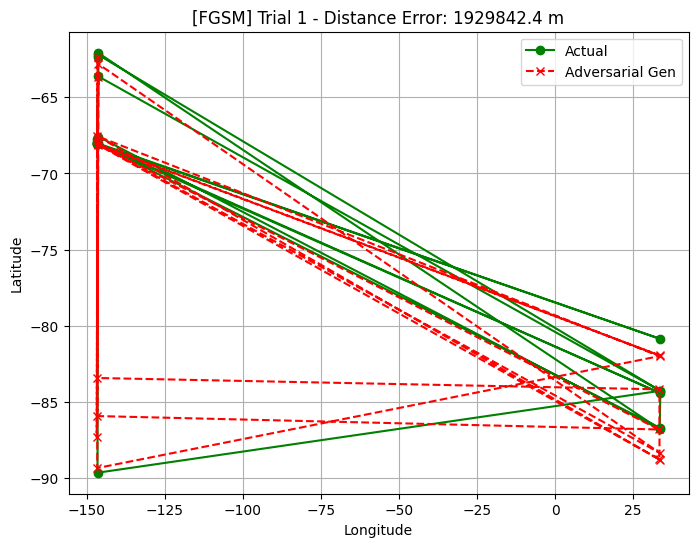

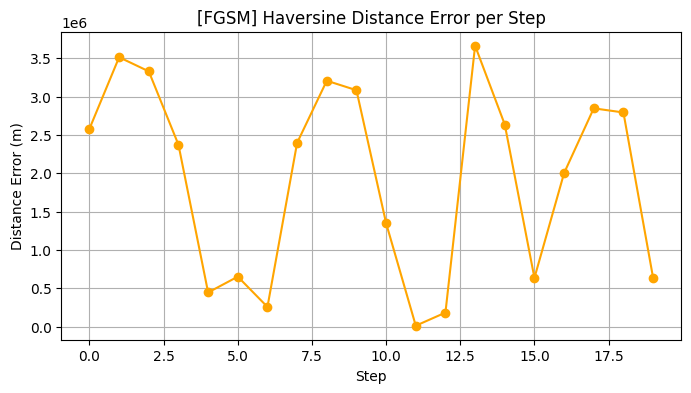

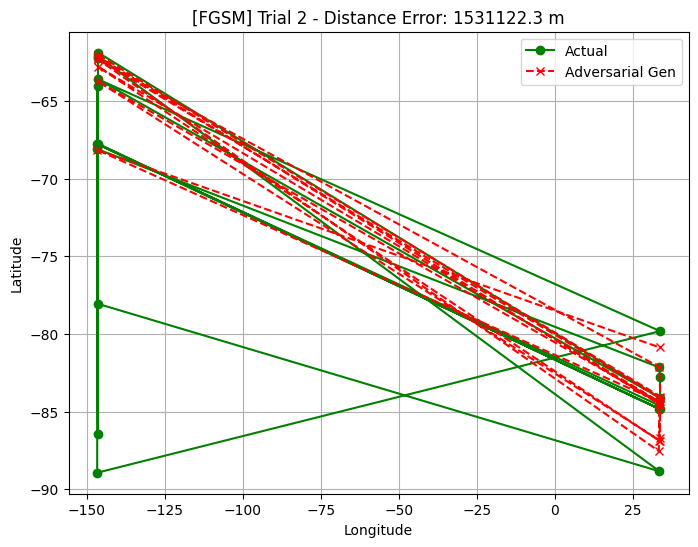

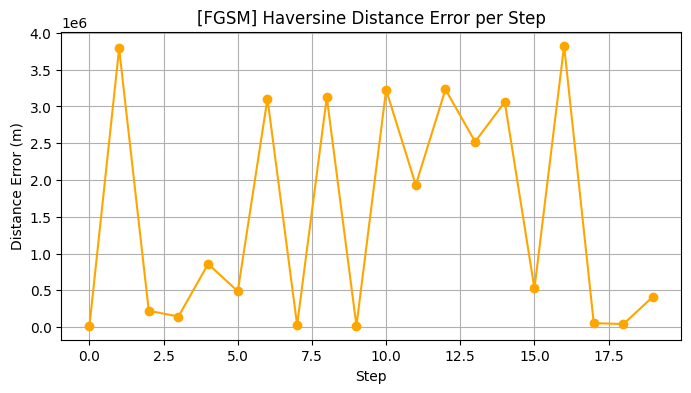

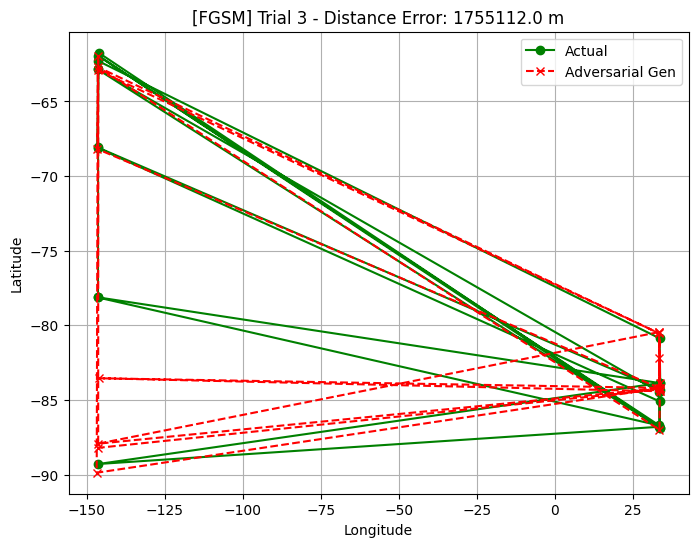

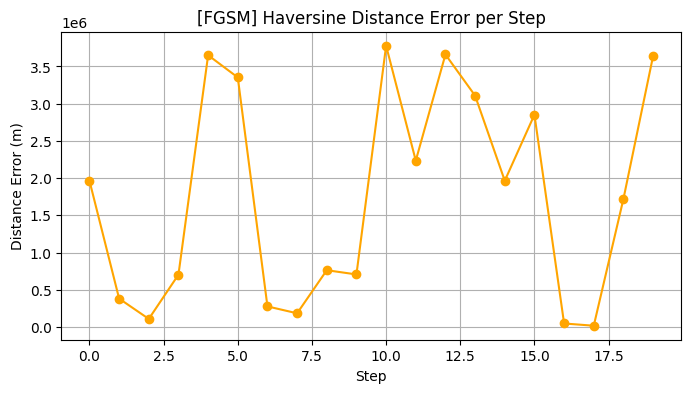

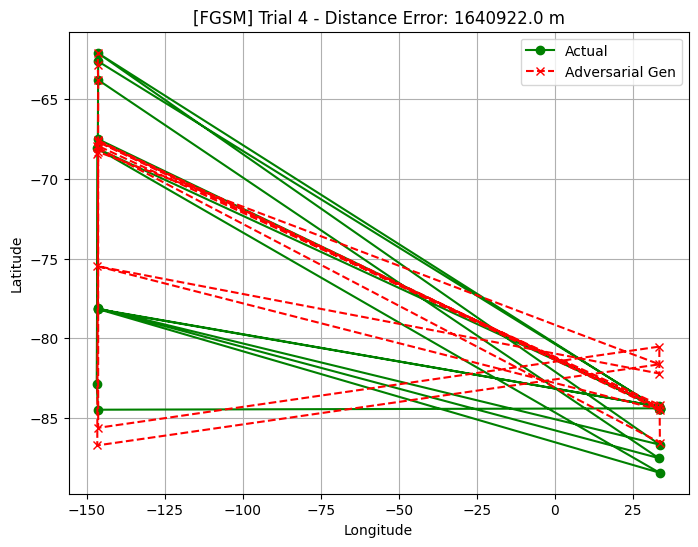

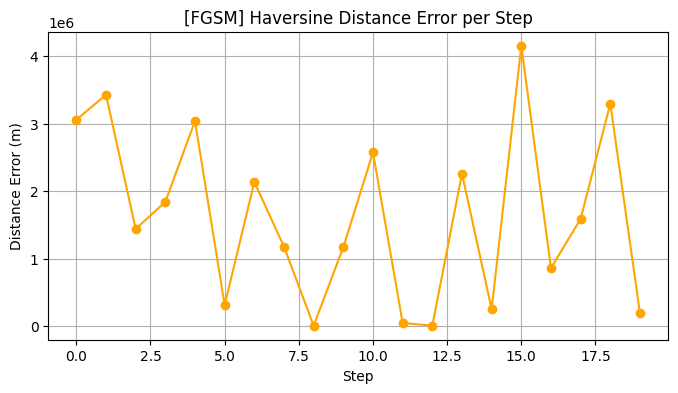

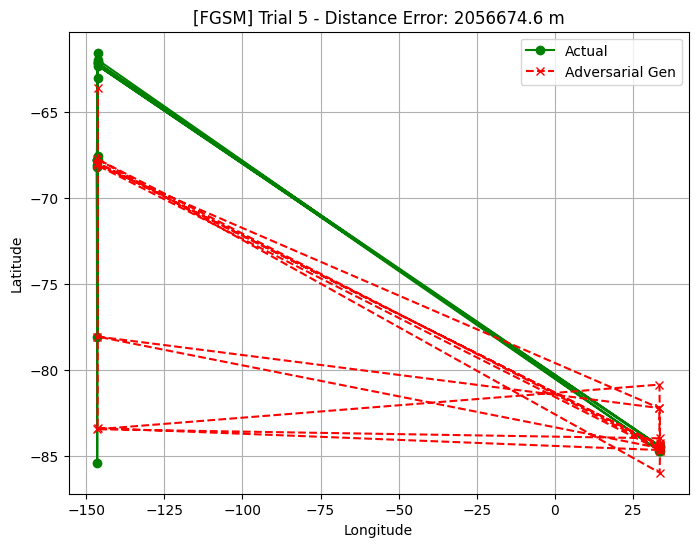

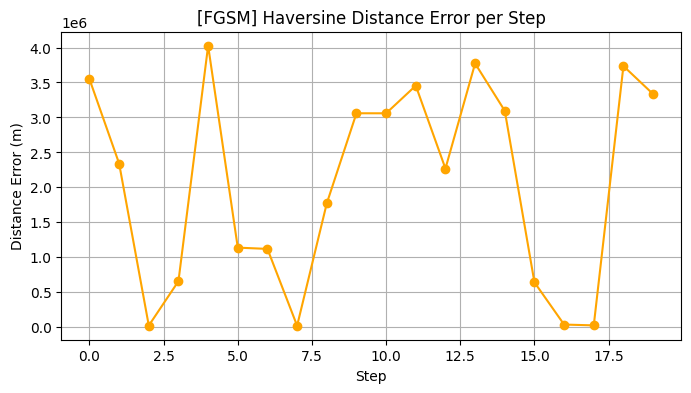

In [36]:
results = compare_under_attack(
    model=model,
    data=val_data,
    vocab_tokens=vocab_tokens,
    attack_fn=fgsm_attack,
    attack_name="FGSM",
    epsilon=0.1,
    n_trials=5
)
